# Audio Segment Classification 



---



---





In [36]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix,accuracy_score


import os, sys, re, pickle, glob
import urllib.request
import zipfile

from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Basic solution**
The basic solution consists of a dataset to build a model that predicts the intonation of a short audio segement. Within the basic solution section, three different models will be evaluated by comparing the performance of each.

The dataset contains of 20,000 audio files. Each audio recording consists of one numeral read in Englinsh, with different intonations and accents.

The 32 numerals read were:

*   Ones sequence ( zero,...,nine)
*   Teens sequence (eleven,...,nineteen)
*   Large sequence (20,30,40,50,60,70,80,90,100,1000, million, billion)


The intonations used were:

*   Neutral
*   Bored
*   Excited
*   Question




## Dataset preparation
In this section, we describe how the data was collected and how the predictors and labels were extracted.




The 20,000 raw audio files were extracted from a zip file and them imported from a local drive.

In [4]:
files = glob.glob('/content/drive/MyDrive/ML_CW/training/Training/*.wav')
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))
len(files)

20000

A sample of an audio file can be listened to below:

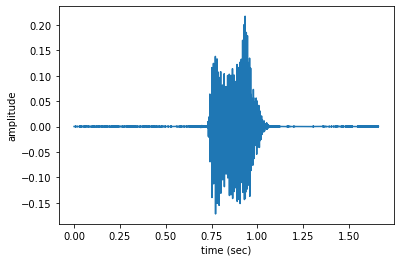

In [5]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

Each audio file was labeled with an intonation and the information collated into a CSV file. The labels file was then imported into the notebook as as dataframe:

In [6]:
labels = pd.read_csv('/content/drive/MyDrive/ML_CW/trainingMLEnd.csv')
labels.head()

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited


In the next cell, we define two functions to extract the follwing features from each audio file:

*   Power
*   Pitch mean
*   Pitch standard deviation
*   Fraction of vioce region


In [28]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for files in tqdm(files):
    fileID = files.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(files,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

By applying the getXy function defined above to all the audio files, we can obtain all the feature(X) and label(y) pairs

In [ ]:
X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=False)

## **Preprocessing**
In the section, we describe how the data was processed in preparation for modelling.

The features and labels extracted from the 20,000 audio files were stored in a dataframe and then merged with the labels data frame to prevent having to perform an extraction each time the notebook was opened as this took approximatley 4 hours to complete.

In [ ]:
data2000 = pd.DataFrame(X,y)
data2000.index.name = 'Digit lables'
data2000 = data2000.reset_index()
data2000 = data2000.rename(columns= {0:'Power',1:'Pitch Mean', 2:'Pitch std', 3:'Fraction of voiced region'})
data2000 = pd.merge(data2000,labels, left_index= True, right_index=True)
data20000.to_csv('data20000_raw.csv')

 The final data looked as followed:

In [113]:
data = pd.read_csv('/content/drive/MyDrive/ML_CW/data20000_raw.csv')
data = data.drop(columns = 'Unnamed: 0')
data.head()

,Digit labels,Power,Pitch Mean,Pitch std,Fraction of voiced region,File ID,digit_label,participant,intonation
0,4,0.010129,208.882834,118.829623,0.215278,0000000.wav,4,S73,question
1,2,0.035339,157.289085,31.784415,0.293333,0000001.wav,2,S88,excited
2,70,0.007153,125.216742,9.361232,0.146552,0000002.wav,70,S5,neutral
3,2,0.013676,134.964540,4.520547,0.084507,0000003.wav,2,S85,bored
4,4,0.052517,181.944641,40.719889,0.494253,0000004.wav,4,S30,excited


As the labels we trying to predict are not in a numerical format, label encoding is applied to the dataframe. Each intonation is assigned the following digit in the newly assigned column titled 'int_encoded':

*   Bored = 0 
*   Excited = 1
*   Neutral = 2
*   Question = 3

In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data = data.drop(columns = ['File ID','participant', 'digit_label'])
data['int_encoded'] =le.fit_transform(data['intonation'])
data.head()

,Digit labels,Power,Pitch Mean,Pitch std,Fraction of voiced region,intonation,int_encoded
0,4,0.010129,208.882834,118.829623,0.215278,question,3
1,2,0.035339,157.289085,31.784415,0.293333,excited,1
2,70,0.007153,125.216742,9.361232,0.146552,neutral,2
3,2,0.013676,134.964540,4.520547,0.084507,bored,0
4,4,0.052517,181.944641,40.719889,0.494253,excited,1


The below code is use to check for missing values within the dataset as these woudld need to be removed.

In [ ]:
#Handling null values
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


As there are no missing values the shape of the features and newly encoded labels are as follows:

In [118]:
X = data[['Power','Pitch Mean','Pitch std','Fraction of voiced region']].values
y = data['int_encoded'].values #Using Intonation
print(X.shape) 
print(y.shape)
print('The labels vector is', y[:5])

(20000, 4)
(20000,)
The labels vector is [3 1 2 0 1]


In order to evaluate the peformance of the models used in this project, we will use the train-split procedure. 80% of the data will be used to train the model adn the remaining 20% of the data will be used for validation after the model is trained.


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16000, 4), (4000, 4), (16000,), (4000,))

## **Dataset visualisation**

In this section, we will use different techniques to visualise the dataset

*   2D/3D plots
*   Intonation Distribution
*   Histogram
*   Scatter Matrix & Heatmap

By evaluating each visualisation technique, it will give a better understanding as to which models to test on the MLEnd dataset.

From a 3D perspective using three of the sample features, it is visible that the data is highly clustered together.

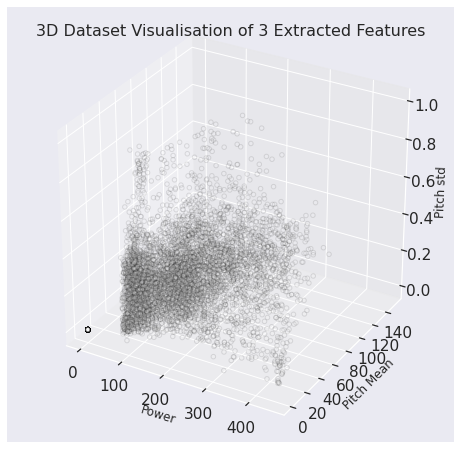

In [52]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], X[:,3], edgecolor='black', c = 'w', alpha = 0.1)
ax.set_xlabel('Power', fontsize=12)
ax.set_ylabel('Pitch Mean', fontsize=12)
ax.set_zlabel('Pitch std', fontsize=12)
plt.title('3D Dataset Visualisation of 3 Extracted Features', fontsize=16)
plt.show()

The 2D perspective displays shows the majority of data points overlapping and the presence of some outliers.

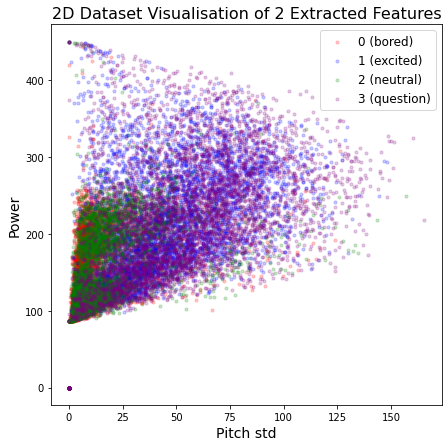

In [22]:
plt.figure(figsize=(7, 7))
X = data[['Pitch std','Pitch Mean']].values
y =data['int_encoded']
target_name = le.classes_

plt.scatter(X[y==0,0], X[y==0,1], s=10 ,alpha=0.2, color= 'red',label='{:d} ({:s})'.format(0, target_name[0]))
plt.scatter(X[y==1,0], X[y==1,1], s=10 ,alpha=0.2, color= 'blue', label='{:d} ({:s})'.format(1, target_name[1]))
plt.scatter(X[y==2,0], X[y==2,1], s=10 ,alpha=0.2, color= 'green', label='{:d} ({:s})'.format(2, target_name[2]))
plt.scatter(X[y==3,0], X[y==3,1], s=10 ,alpha=0.2, color= 'purple', label='{:d} ({:s})'.format(3, target_name[3]))

plt.legend(fontsize=12)
plt.xlabel('Pitch std', fontsize=14)
plt.ylabel('Power', fontsize=14)
plt.title('2D Dataset Visualisation of 2 Extracted Features', fontsize=16)
plt.show()


Analysing the intonation distibution shows that there is an even distribution of classes.

intonation
bored       5000
excited     5000
neutral     5000
question    5000
dtype: int64


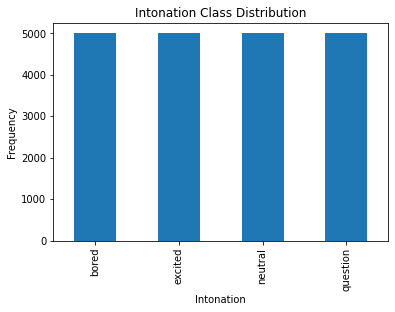

In [ ]:
print(data.groupby('intonation').size())
count_classes = (data.groupby('intonation').size())
count_classes.plot(kind = 'bar')
plt.title('Intonation Class Distribution')
plt.ylabel('Frequency')
plt.xlabel('Intonation')
plt.show()

The histograms show that the feature data is skewed to the right with outliers. The variation within each feature could be due to the variance of demographics providing the audios sample. E.g higher pitched voice and lower deeper voices.

The histogram for the Fraction of voiced region feature displayed a slight Gaussian distribution.

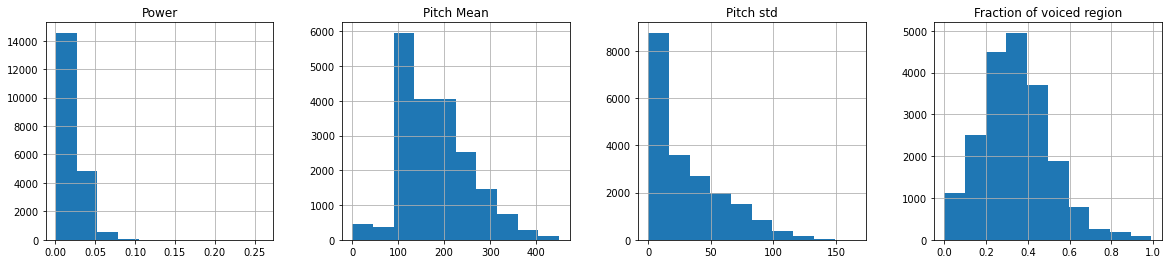

In [ ]:
features = ['Power','Pitch Mean','Pitch std','Fraction of voiced region']
data_vis = data.loc[:, features]

fig, (a1, a2, a3, a4) = plt.subplots(1,4, figsize=(20,4))
data_vis.hist(column='Power',  ax=a1)
data_vis.hist(column='Pitch Mean', ax=a2)
data_vis.hist(column='Pitch std', ax=a3)
data_vis.hist(column='Fraction of voiced region', ax=a4)
plt.show()

The scatter matrix and heatmap highlight if there is any colinearity between the features. A strong correlation is not observed between any variable, but some correlation can be seen between Pitch Mean-Pitch std and Power-fractin of voice region.

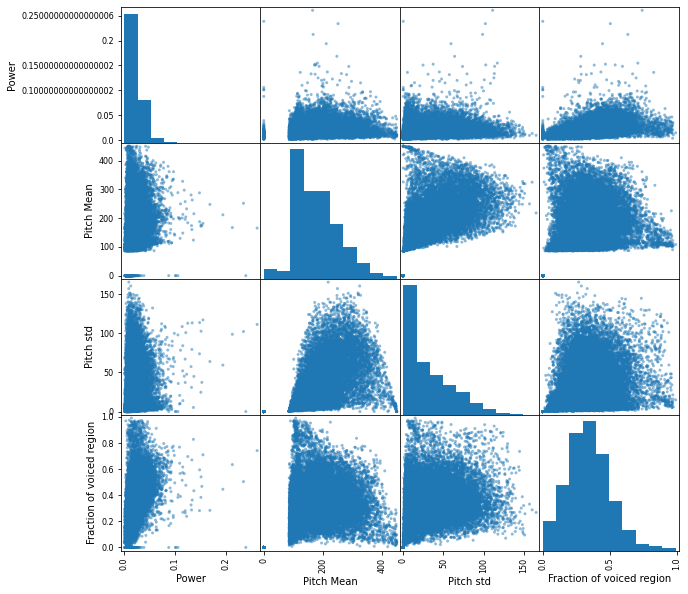

In [ ]:
# scatter plot matrix
sc = pd.plotting.scatter_matrix(data_vis, figsize=(10,10))
plt.show()

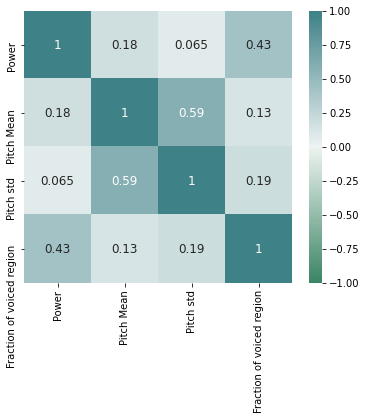

In [24]:
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(6,5))
sns.heatmap(data_vis.corr(),vmin=-1, vmax=1, cmap=sns.diverging_palette(150,200, as_cmap=True),annot=True, ax=ax, annot_kws={"size": 12})
plt.show()

In summary, the data visualization has revealed that the data points are highly clustered and do not displayed a normal distribution. From this it can be assumed that any model used for classification may not sucessfuly classify the training, validation or future simialr datasets.

## **Model description**

Based on the project problem and visualisation of the data, the following algorithims were trained with the dataset.

1. Support Vector Machine (SVM)
2. K-Nearest Neighbors (KNN)
3. Random Forest 


## **Training, Validation & Performance Evaluation**



#### Support Vector Machine


---



---



It has been determined that the distribution of the dataset is not Gaussian. Therefore, we normalize the features values in the training and validation datasets as the fetaure values have varying scales.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X_train_n= scaler.fit_transform(X_train)
X_val_n= scaler.fit_transform(X_val)

After applying the SVM model to the normalized 
data a faily average accuracy is achieved.

In [ ]:
from sklearn import svm
SVM  = svm.SVC() 
SVM.fit(X_train_n,y_train)

#Calculate the training and accuracy values
yt_p = SVM.predict(X_train_n)
yv_p = SVM.predict(X_val_n)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.543875
Validation  Accuracy 0.5485


The following cell performs hyperparamter tuning to select the optimal parameters for this algorithm. These parameters will then used to update the SVM model and to recalcualte the accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV
gamma = list(range(1,10))
C = list(range(1,10))
kernel = ('linear', 'rbf')
parameters = dict(gamma=gamma, C=C, kernel=kernel)
SVM2 = svm.SVC()
grid = GridSearchCV(SVM2, parameters)
grid.fit(X_train_n,y_train)
grid.best_params_

{'C': 8, 'gamma': 9, 'kernel': 'rbf'}

It can be observed that the accuracy of the model has slightly improved after the application of the optimal paramters.

In [ ]:
from sklearn import svm
SVM  = svm.SVC(kernel= 'rbf',gamma= 9,C=8) 
SVM.fit(X_train_n,y_train)

#Calculate the training and accuracy values
yt_p = SVM.predict(X_train_n)
yv_p = SVM.predict(X_val_n)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.555125
Validation  Accuracy 0.55825


#### K-Nearest Neighbors

---
---








KNN is the next model to be trained on the dataset and in comparison to the SVM model a worse accuracy was achieved.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric='euclidean')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

#Calculate the training and accuracy values
yt_p_knn = knn.predict(X_train)
yv_p_knn = knn.predict(X_val)
print('Training Accuracy', np.mean(yt_p_knn==y_train))
print('Validation  Accuracy', np.mean(yv_p_knn==y_val))

Training Accuracy 0.631875
Validation  Accuracy 0.445


Hyperparamter tuning was also applied to the KNN model:

In [ ]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,100))
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knn_2 = KNeighborsClassifier()
gridknn = GridSearchCV(knn_2, hyperparameters, cv=10)
best_model = gridknn.fit(X_train, y_train)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 98


After applying the suggest optimal paramaters from the previous cell, the validation accuracy for this model improved.

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=98, p=1,leaf_size=1, metric='euclidean')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

#Calculate the training and accuracy values
yt_p_knn = knn.predict(X_train)
yv_p_knn = knn.predict(X_val)
print('Training Accuracy', np.mean(yt_p_knn==y_train))
print('Validation  Accuracy', np.mean(yv_p_knn==y_val))

Training Accuracy 0.5170625
Validation  Accuracy 0.49475


The below two cells display confusion matricies for this model. The first cell output displays the number of correctly classified audio files by intonation. The second cell output displays teh results as a percentage

In [42]:
cm = confusion_matrix(y_val, y_pred_knn)
print(cm)

[[613  75 296  33]
 [ 61 442 132 315]
 [383 126 418  58]
 [ 61 398  83 506]]


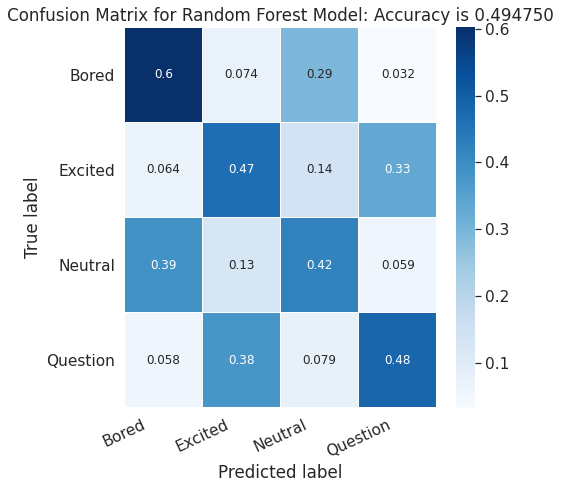

In [45]:
matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
KNN_acc = accuracy_score(y_val, yv_p_knn)

plt.figure(figsize=(7,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':12}, cmap=plt.cm.Blues, linewidths=0.2)

class_names = ['Bored', 'Excited', 'Neutral', 'Question']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model: Accuracy is %1f' % KNN_acc)
plt.show()

By viewing the second confusion matrix on a larger scale, it can be observed that the 'Bored' intonation was classified correctly the most at 60%. 

The KNN model struggled to classify the Neutral intonation correctly. Nearly a fifth of the time it was classifed as Bored and just over a tenth of the time as excited.

The matrix shows that Bored intonations were mostly misclassified as Neutral and Neutral intonation mostly misclassified as Bored.

Similarly, Excited intonations were mostly missclassified as Question and Question intonation mostly misclassified as Excited.


#### Random Forest


---



---



When applying the Random forest algorithim to the traning data set an accuracy of 1 was determined, which shows overfitting of the model. Therefore, hyperparamter tuning would need to be applied to obtain a more reflective training accuracy and inturn a validation accuracy.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)

#Calculate the training and accuracy values
yt_p_RF = RF.predict(X_train)
yv_p_RF = RF.predict(X_val)
print('Training Accuracy', np.mean(yt_p_RF==y_train))
print('Validation  Accuracy', np.mean(yv_p_RF==y_val))



Training Accuracy 1.0
Validation  Accuracy 0.548


Hyperparemter tuning was calculated for the model:

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
RF2 = RandomForestClassifier()
RF2_Grid = GridSearchCV(estimator = RF2, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
RF2_Grid.fit(X_train, y_train)

In [ ]:
RF2_Grid.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 17}

After applying the optimal hyperparamters the training validation has reduced dramtically to 0.53 and the validation accuracy has decreased. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(bootstrap=True, max_depth =4, max_features='auto',min_samples_leaf =1,min_samples_split=5,n_estimators=17, n_jobs=6, random_state=0)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)

#Calculate the training and accuracy values
yt_p_RF = RF.predict(X_train)
yv_p_RF = RF.predict(X_val)
print('Training Accuracy', np.mean(yt_p_RF==y_train))
print('Validation  Accuracy', np.mean(yv_p_RF==y_val))



Training Accuracy 0.5349375
Validation  Accuracy 0.525


The below two cells display confusion matricies for this model. The first cell output displays the number of correctly classified audio files by intonation. The second cell output displays the results as a percentage

In [ ]:
cm = confusion_matrix(y_val, y_pred_RF)
print(cm)

[[676  91 165  43]
 [ 69 523 110 313]
 [486 158 268  91]
 [ 48 276  50 633]]


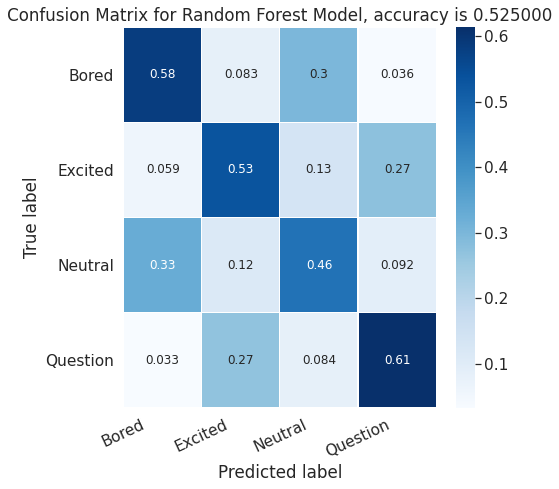

In [ ]:
matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
RF_acc = accuracy_score(y_val, yv_p_RF)

plt.figure(figsize=(7,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':12}, cmap=plt.cm.Blues, linewidths=0.2)

class_names = ['Bored', 'Excited', 'Neutral', 'Question']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model, accuracy is %1f' % RF_acc)
plt.show()

By viewing the second confusion matrix on a larger scale, it can be observed that the 'Question' intonation was classified correctly the most at 61%, which differs from the KNN model that correctly classified the 'Bored' 
intonation the most.

The RF model also struggled to classify the Neutral intonation correctly. Nearly a third of the time it was classifed as Bored and just over a tenth of the time as excited.

Similarly to the SVM model, the Bored intonation was mostly missclassified as Neutral and Excited was mostly missclassified as Question.

## Conclusion

By comparing the validation accuracy of each model, it can be determined that the SVM model is the best of all three model at classifying the dataset. However, the accuracy of the model is not great. As the problem was to classisy four intonations (labels), the worst accuracy woudl be 0.25. Hyperperameter tuning was used to improve the model, but the effect was mininal.

Futher improvements to the model could be to you differnet sound features as a predictor .




# **Advanced Solution**
The advanced solution consists of using the dataset to build a model that predicts a digit between 0-9 in a short audio segement. For example: '*one potato*'

Within the advanced solution section, three different models will be evaluated by comparing the performance of each.

## Dataset preparation
The dataset preperation used for the advanced solution on the dataset is the same for the basic solution. Please refer to the above section.

To create phrase audio segements, Google translate speech function was used and the speech was recorded. These audio files were edited to removed dead space and backroung noise. Ten files were created in total.

In [81]:
google_files = glob.glob('/content/drive/MyDrive/ML_CW/training/google_digits/*.wav')
len(google_files)

10

An example of an audio file can be herd here:

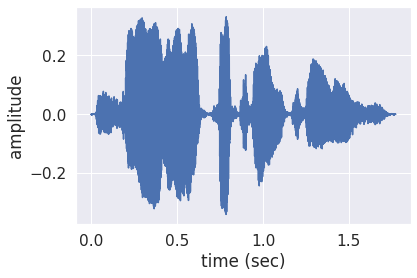

In [82]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(google_files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(google_files[n]))

Each phrase was labeled with its corresponding digit and the information collated into a CSV file. The google labels file was then imported into the notebook as as dataframe:

In [85]:
google_labels = pd.read_csv('/content/drive/MyDrive/ML_CW/training/google_digits/google_labels.csv')
google_labels

,File ID,Labels
0,Google_0_potato.wav,0
1,Google_1_potato.wav,1
2,Google_2_potato.wav,2
3,Google_3_potato.wav,3
4,Google_4_potato.wav,4
5,Google_5_potato.wav,5
6,Google_6_potato.wav,6
7,Google_7_potato.wav,7
8,Google_8_potato.wav,8
9,Google_9_potato.wav,9


Using a modifed getXy function from the basic solution section, the four features were extracted from the recorded google phrases.

In [90]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for files in tqdm(files):
    fileID = files.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['Labels'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(files,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

In [95]:
X_g,y_g = getXy(google_files[0:10],labels_file=google_labels,scale_audio=True, onlySingleDigit=False)

100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


In [99]:
google_data = pd.DataFrame(X_g,y_g)
google_data.index.name = 'Digit labels'
google_data = google_data.reset_index()
google_data = google_data.rename(columns= {0:'Power',1:'Pitch Mean', 2:'Pitch std', 3:'Fraction of voiced region'})
google_data

,Digit labels,Power,Pitch Mean,Pitch std,Fraction of voiced region
0,0,0.057557,232.389642,46.645502,0.777778
1,1,0.024713,225.505275,45.679657,0.817391
2,2,0.036705,227.520462,55.378414,0.666667
3,3,0.036145,228.723786,53.253141,0.698413
4,4,0.055319,224.024826,50.021056,0.655844
5,5,0.021570,221.354619,44.802124,0.641221
6,6,0.025932,211.504032,46.193760,0.500000
7,7,0.036414,230.211587,48.012484,0.693878
8,8,0.029380,214.710466,42.998311,0.569231
9,9,0.022096,220.614107,43.091107,0.704225


These 10 feature label pairs will be tested on the selected model to evaluate if they can be correctly classified.

In [119]:
X_g = google_data[['Power','Pitch Mean','Pitch std','Fraction of voiced region']].values
y_g = google_data['Digit labels'].values 
print(X_g.shape) 
print(y_g.shape)
print('The labels vector is', y_g[:5])

(10, 4)
(10,)
The labels vector is [0 1 2 3 4]


## **Preprocessing**
In the section, we describe how the data was processed in preparation for modelling.

We will be reusing the same dataset that was used in the basic solution. This will be imported from a local drive. As the model will be trained to predict digits between 0-9, we filtered the dataset to create a new dataframe that consist of only these digits.

In [56]:
ad_data = pd.read_csv('/content/drive/MyDrive/ML_CW/data20000_raw.csv').drop(columns = 'Unnamed: 0')

ad09_data = ad_data.loc[(ad_data.digit_label == 0)|(ad_data.digit_label == 1)|(ad_data.digit_label == 2)
                         |(ad_data.digit_label == 3)|(ad_data.digit_label == 4)|(ad_data.digit_label == 5)
      |(ad_data.digit_label == 6)|(ad_data.digit_label == 7)|(ad_data.digit_label == 8)|(ad_data.digit_label == 9)]

ad09_data.head()

,Digit labels,Power,Pitch Mean,Pitch std,Fraction of voiced region,File ID,digit_label,participant,intonation
0,4,0.010129,208.882834,118.829623,0.215278,0000000.wav,4,S73,question
1,2,0.035339,157.289085,31.784415,0.293333,0000001.wav,2,S88,excited
3,2,0.013676,134.964540,4.520547,0.084507,0000003.wav,2,S85,bored
4,4,0.052517,181.944641,40.719889,0.494253,0000004.wav,4,S30,excited
6,2,0.027461,109.742686,18.208426,0.120000,0000006.wav,2,S136,neutral


The below code is use to check for missing values within the dataset as these woudld need to be removed.

In [57]:
#Handling null values
if np.sum(np.isnan(XAD)):
  idx = np.isnan(XAD).sum(1)>0
  XAD = XAD[~idx]
  yAD = yAD[~idx]
print(np.sum(np.isnan(XAD)))

0


As there are no missing values the shape of the features and digit labels are as follows:

In [115]:
XAD = ad09_data[['Power','Pitch Mean','Pitch std','Fraction of voiced region']].values
yAD =ad09_data['digit_label'].values 
print(XAD.shape)
print(yAD.shape)
print('The labels vector is', yAD[:5])

(6533, 4)
(6533,)
The labels vector is [4 2 2 4 2]


In order to evaluate the peformance of the models used in this project, we will use the train-split procedure. 80% of the data will be used to train the model adn the remaining 20% of the data will be used for validation after the model is trained.


In [59]:
XAD_train, XAD_val, yAD_train, yAD_val = train_test_split(XAD,yAD,test_size=0.20)
XAD_train.shape, XAD_val.shape, yAD_train.shape, yAD_val.shape

((5226, 4), (1307, 4), (5226,), (1307,))

## **Dataset visualisation**

In this section, we will use different techniques to visualise the dataset

*   3D plot
*   Digit class Distribution
*   Histogram
*   Scatter Matrix & Heatmap

By evaluating each visualisation technique, it will give a better understanding as to which models to test on the MLEnd dataset.

From a 3D perspective using three of the sample features, it is visible that the data is highly clustered together.

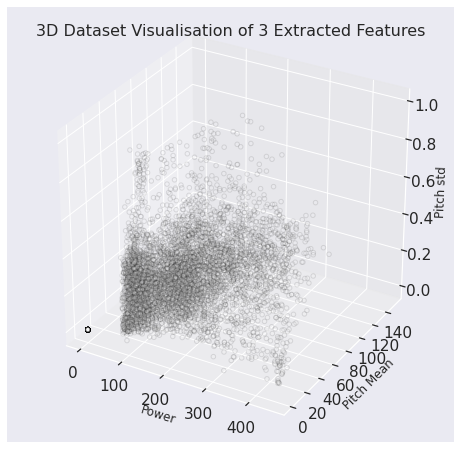

In [60]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], X[:,3], edgecolor='black', c = 'w', alpha = 0.1)
ax.set_xlabel('Power', fontsize=12)
ax.set_ylabel('Pitch Mean', fontsize=12)
ax.set_zlabel('Pitch std', fontsize=12)
plt.title('3D Dataset Visualisation of 3 Extracted Features', fontsize=16)
plt.show()

Analysing the intonation distibution shows that the data is slightly imbalanced. The number digit 7 and 4 has the fewest data points out of all the labels whilst the digit 6 and 9 have the most. 

digit_label
0    655
1    663
2    652
3    650
4    641
5    650
6    668
7    638
8    653
9    663
dtype: int64


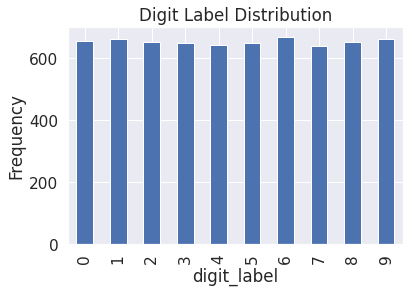

In [61]:
print(ad09_data.groupby('digit_label').size())
count_classes = (ad09_data.groupby('digit_label').size())
count_classes.plot(kind = 'bar')
plt.title('Digit Label Distribution')
plt.ylabel('Frequency')
plt.show()

The histograms show that the feature data is skewed to the right with outliers. The variation within each feature could be due to the variety of demographics providing the audios sample. E.g higher pitched voice and lower deeper voices.


The histogram for the Fraction of voiced region feature displayed a slight Gaussian distribution.

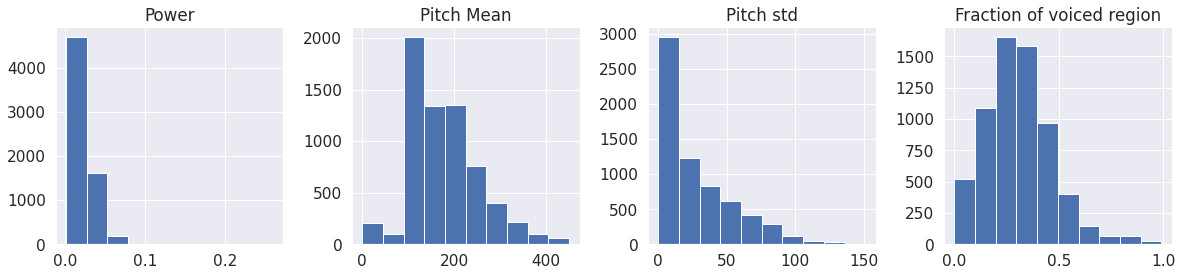

In [63]:
features = ['Power','Pitch Mean','Pitch std','Fraction of voiced region']
data_vis_ad = ad09_data.loc[:, features]

fig, (a1, a2, a3, a4) = plt.subplots(1,4, figsize=(20,4))
data_vis_ad.hist(column='Power',  ax=a1)
data_vis_ad.hist(column='Pitch Mean', ax=a2)
data_vis_ad.hist(column='Pitch std', ax=a3)
data_vis_ad.hist(column='Fraction of voiced region', ax=a4)
plt.show()

The scatter matrix and heatmap show if there is any colinearity between the features. A strong correlation is not observed between any variable, but some correlation can be seen between Pitch Mean-Pitch std and Power-fractin of voice region.

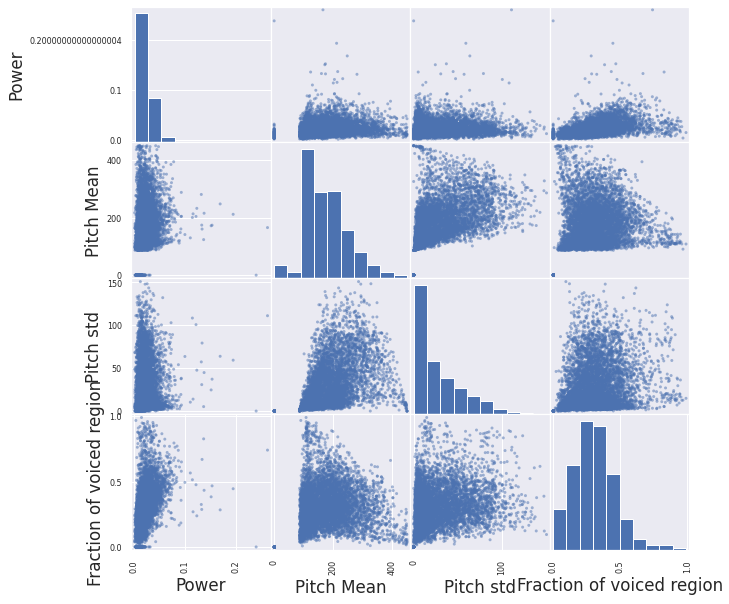

In [64]:
sc = pd.plotting.scatter_matrix(data_vis_ad, figsize=(10,10))
plt.show()

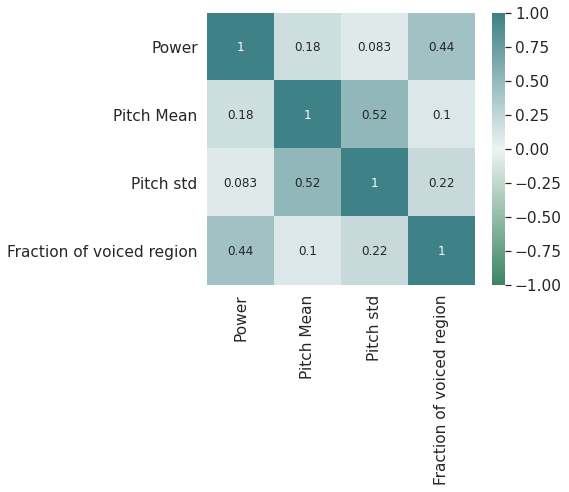

In [65]:
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(6,5))
sns.heatmap(data_vis_ad.corr(),vmin=-1, vmax=1, cmap=sns.diverging_palette(150,200, as_cmap=True),annot=True, ax=ax, annot_kws={"size": 12})
plt.show()

In summary, the data visualization has reveald that the data points are highly clustered and do not displayed a normal distribution. From this it can be assumed that any model used for classification may not sucessfuly classify the training, validation or future simialr datasets.

## **Model description**

Based on the project problem and visualisation of the data, the following algorithims were trained with the dataset.

1. Support Vector Machine (SVM)
2. K-Nearest Neighbors (KNN)
3. Random Forest 

## **Training, Validation & Performance Evaluation**


#### Support Vector Machine


---



---



It has been determined that the distribution of the dataset is not Gaussian. Therefore, we normalize the features values in the training and validation datasets as the fetaure values have varying scales.

In [ ]:
scaler = MinMaxScaler() 
XAD_train_n= scaler.fit_transform(XAD_train)
XAD_val_n= scaler.fit_transform(XAD_val)

After applying the SVM model to the normalized data a faily average accuracy is achieved.

In [ ]:
SVM  = svm.SVC() 
SVM.fit(XAD_train_n,yAD_train)

#Calculate the training and accuracy values
yt_p = SVM.predict(XAD_train_n)
yv_p = SVM.predict(XAD_val_n)
print('Training Accuracy', np.mean(yt_p==yAD_train))
print('Validation  Accuracy', np.mean(yv_p==yAD_val))

Training Accuracy 0.25066972828166856
Validation  Accuracy 0.21729150726855395


The following cell performs hyperparamter tuning to select the optimal parameters for this algorithm. These parameters will then used to update the SVM model and to recalcualte the accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV
gamma = list(range(1,10))
C = list(range(1,10))
kernel = ('linear', 'rbf')
parameters = dict(gamma=gamma, C=C, kernel=kernel)
SVM2 = svm.SVC()
grid = GridSearchCV(SVM2, parameters)
grid.fit(XAD_train_n,yAD_train)
grid.best_params_

{'C': 5, 'gamma': 9, 'kernel': 'rbf'}

After the implementation of the optimal paramters, the traning accuracy slightly improved, but the validation accuracy decreased.

In [ ]:
from sklearn import svm
SVM  = svm.SVC(kernel= 'rbf',gamma= 9,C=5) 
SVM.fit(XAD_train_n,yAD_train)

#Calculate the training and accuracy values
yt_p = SVM.predict(XAD_train_n)
yv_p = SVM.predict(XAD_val_n)
print('Training Accuracy', np.mean(yt_p==yAD_train))
print('Validation  Accuracy', np.mean(yv_p==yAD_val))

Training Accuracy 0.26827401454267125
Validation  Accuracy 0.21652639632746748


#### K-Nearest Neighbors


---



---



The KNN model produced ad poor accuracy of 0.14 as there are 10 labels to be classified.

In [68]:
knn = KNeighborsClassifier(metric='euclidean')
knn.fit(XAD_train, yAD_train)
yAD_pred_knn = knn.predict(XAD_val)

#Calculate the training and accuracy values
yt_p_knn = knn.predict(XAD_train)
yv_p_knn = knn.predict(XAD_val)
print('Training Accuracy', np.mean(yt_p_knn==yAD_train))
print('Validation  Accuracy', np.mean(yv_p_knn==yAD_val))

Training Accuracy 0.37791810179869884
Validation  Accuracy 0.14154552410099464


Hyperparemters were tuned using a grid search.

In [ ]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,100))
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knn_2 = KNeighborsClassifier()
gridknn = GridSearchCV(knn_2, hyperparameters, cv=10)
best_model = gridknn.fit(XAD_train, yAD_train)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 18


After tuning, both the training and validation acuracy decreeased.

In [67]:
knn = KNeighborsClassifier(n_neighbors=18, p=1,leaf_size=1, metric='euclidean')
knn.fit(XAD_train, yAD_train)
yAD_pred_knn = knn.predict(XAD_val)

#Calculate the training and accuracy values
yt_p_knn = knn.predict(XAD_train)
yv_p_knn = knn.predict(XAD_val)
print('Training Accuracy', np.mean(yt_p_knn==yAD_train))
print('Validation  Accuracy', np.mean(yv_p_knn==yAD_val))

Training Accuracy 0.2537313432835821
Validation  Accuracy 0.1331293037490436


The below two cells display confusion matricies for this model. The first cell output displays the number of correctly classified audio files by digit. The second cell output displays the results as a percentage

In [73]:
cm = confusion_matrix(yAD_val, yAD_pred_knn)
print(cm)

[[40 17 10  9 12  5  6  4  7 12]
 [31 27 18 10  8  8  1  8  4 12]
 [20 19 20 13 15  9  9  9  9  5]
 [30 21 13 15  8 16  9 11  7  9]
 [29 26  9 20  7  9 12  4  3  7]
 [25 21 15  9  8 12  9  8  3 16]
 [22 17 14 15  7  9 37  9 10  1]
 [30 25  9  9 10  8  8 10  3  7]
 [27 21 21 16  8 11 14 10  8  8]
 [29 25 16 14 11  9  9 10  3  9]]


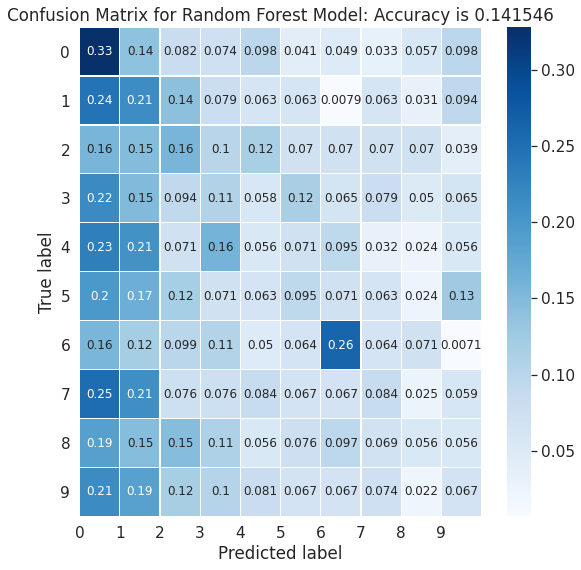

In [75]:
matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Use this line to nomrlaise and view as a percentage
KNN_acc = accuracy_score(yAD_val, yv_p_knn)

plt.figure(figsize=(9,9))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':12}, cmap=plt.cm.Blues, linewidths=0.2)

class_names = ['0','1','2','3','4','5','6','7','8','9']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model: Accuracy is %1f' % KNN_acc)
plt.show()

The confusion matrix shows that the digit 0 was classified correctly the most at 33%. followed by digit 6 at 26%. This is something to note as the digit 6 had the most data points when observing the digit class distribution.

The matrix also shows that all of the digits were mostly incorrectly classified as either 0 or 1.

#### Random Forest


---



---


When applying the Random forest algorithim to the traning data set an accuracy of 1 was determined, which shows overfitting of the model. Therefore, hyperparamter tuning would need to be applied to obtain a more reflective training accuracy and inturn a validation accuracy.

In [76]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(XAD_train, yAD_train)
yAD_pred_RF = RF.predict(XAD_val)


#Calculate the training and accuracy values
yt_p_RF = RF.predict(XAD_train)
yv_p_RF = RF.predict(XAD_val)
print('Training Accuracy', np.mean(yt_p_RF==yAD_train))
print('Validation  Accuracy', np.mean(yv_p_RF==yAD_val))

Training Accuracy 1.0
Validation  Accuracy 0.188982402448355


Hyperparemter tuning was calculated for the model:

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
RF2 = RandomForestClassifier()
RF2_Grid = GridSearchCV(estimator = RF2, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
RF2_Grid.fit(XAD_train, yAD_train)
RF2_Grid.best_params_

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:  2.4min finished


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 33}

After applying the optimal hyperparamters the training validation has reduced dramtically, but it improved the validation accuracy to 0.20.

In [77]:
RF = RandomForestClassifier(bootstrap=True, max_depth =4, max_features='sqrt',min_samples_leaf =1,min_samples_split=2,n_estimators=33, n_jobs=6, random_state=0)
RF.fit(XAD_train, yAD_train)
yAD_pred_RF = RF.predict(XAD_val)

#Calculate the training and accuracy values
yt_p_RF = RF.predict(XAD_train)
yv_p_RF = RF.predict(XAD_val)
print('Training Accuracy', np.mean(yt_p_RF==yAD_train))
print('Validation  Accuracy', np.mean(yv_p_RF==yAD_val))



Training Accuracy 0.24856486796785304
Validation  Accuracy 0.2088752869166029


The below two cells display confusion matricies for this model. The first cell output displays the number of correctly classified audio files by digit. The second cell output displays the results as a percentage.

In [78]:
cm = confusion_matrix(yAD_val, yAD_pred_RF)
print(cm)

[[13 26 33  2  5  7 17 11  1  7]
 [18 42 24  0  1  8  4 17  0 13]
 [ 8 14 53  3 11  7 17  5  0 10]
 [10 21 45  2 14 10 22  5  0 10]
 [19  5 45  4 12  6 21  3  0 11]
 [12 13 20  0 12  7 21 21  0 20]
 [ 1  3 14  1  6  5 97  2  1 11]
 [13 19 18  0  5 10 15 16  0 23]
 [12  8 41  1 19  3 35  6  1 18]
 [15 24 13  2  9  2 24 16  0 30]]


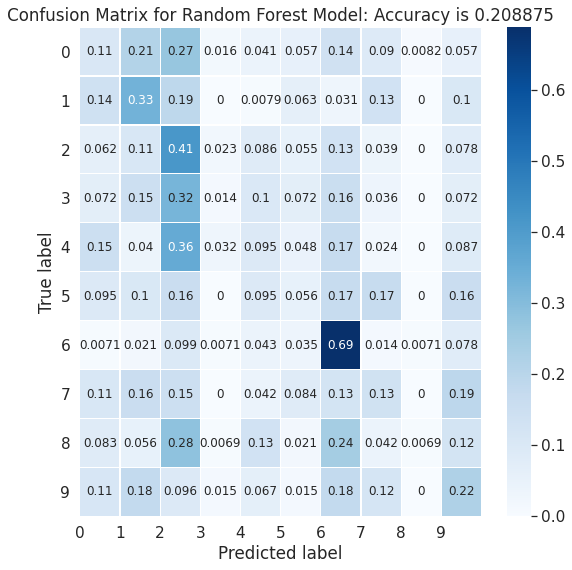

In [79]:
matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Use this line to nomrlaise and view as a percentage
RF_acc = accuracy_score(yAD_val, yv_p_RF)

plt.figure(figsize=(9,9))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':12}, cmap=plt.cm.Blues, linewidths=0.2)

class_names = ['0','1','2','3','4','5','6','7','8','9']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model: Accuracy is %1f' % RF_acc)
plt.show()



The confusion matrix shows that the digit 6 was classified correctly the most at 69%, which was also observed in the KNN model.

The matrix also shows that all of the digits were mostly incorrectly classified as either 2 or 3.

## Conclusion
By comparing the validation accuracy of each model, it can be determined that the SVM model is the best of all three model at classifying the dataset. However, the accuracy of the model is not great. As the problem was to classify ten digit (labels), the worst accuracy woudl be 0.10. Hyperperameter tuning was used to improve the model, but it had an adverse effect.



## Predicting the Google Phrases

The SVM model was unable to correctly classify any of the google phrases and an accuracy on 0.1 was achieved, which is the worst scenario possible.

As the model was initially trained on just the features from digits, it can be assumed that the addition of the phrase altered the feature values of each data point, making them similar. 

Looking at the google_data, dataframe in the Dataset preparation section, it is evident that the 10 recorded audio phrases are similar in characteristics. Hence why they were all classified as the same digit.

In [111]:
google_predict = SVM.predict(X_g)
print('Predicted labels',google_predict)
print('Validation  Accuracy', np.mean(google_predict==y_g))

Predicted labels [5 5 5 5 5 5 5 5 5 5]
Validation  Accuracy 0.1
